### DATA LOADING

In [1]:
import numpy as np
import pandas as pd

In [2]:
books_path = './data/BX-Books.csv'
books_ratings_path = './data/BX-Book-Ratings.csv'
# users_path = './data/BX-Users.csv'

In [3]:
books_df = pd.read_csv(books_path, encoding="latin-1", sep=";", on_bad_lines="skip", low_memory=False, na_values='NULL')
books_ratings_df = pd.read_csv(books_ratings_path, encoding="latin-1", sep=";", on_bad_lines="skip", na_values='NULL')
# users_df = pd.read_csv(users_path, encoding="latin-1", sep=";", on_bad_lines="skip", na_values='NULL')

In [4]:
books_df.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [5]:
books_ratings_df.isna().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [6]:
books_ratings_df['User-ID'] = books_ratings_df['User-ID'].astype(str)
books_ratings_df.head() 

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [7]:
ISBN_df = books_df['ISBN'].to_frame()
ISBN_df.head()

,ISBN
0,0195153448
1,0002005018
2,0060973129
3,0374157065
4,0393045218


In [8]:
books_with_rating_df = ISBN_df.merge(books_ratings_df, how='left', on='ISBN')
books_with_rating_df.head()

,ISBN,User-ID,Book-Rating
0,0195153448,2,0.0
1,0002005018,8,5.0
2,0002005018,11400,0.0
3,0002005018,11676,8.0
4,0002005018,41385,0.0


In [9]:
books_with_rating_df = books_with_rating_df.dropna(subset=['ISBN', 'User-ID'])
books_with_rating_df.head()

,ISBN,User-ID,Book-Rating
0,0195153448,2,0.0
1,0002005018,8,5.0
2,0002005018,11400,0.0
3,0002005018,11676,8.0
4,0002005018,41385,0.0


In [10]:
books_df = books_df[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication']]
books_df.dtypes

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication    object
dtype: object

### KNN MODEL

In [11]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

df = books_with_rating_df.copy()

df['book_code'] = df['ISBN'].astype('category').cat.codes
df['user_code'] = df['User-ID'].astype('category').cat.codes

ratings = df["Book-Rating"].values

sparse_book_user_matrix = csr_matrix((ratings, (df['user_code'], df['book_code'])))

In [12]:
knn_users = NearestNeighbors(metric="cosine", algorithm="brute")
knn_users.fit(sparse_book_user_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [13]:
def recommend_books_knn(user_id, n_recommendations=5):
    if user_id not in df["User-ID"].values:
        return "User not found"

    user_idx = df[df["User-ID"] == user_id].index[0]
    user_code = df.loc[user_idx, 'user_code']

    distances, indices = knn_users.kneighbors(sparse_book_user_matrix[user_code].reshape(1, -1), n_neighbors=n_recommendations + 1)

    recommended_books = df.iloc[indices.flatten()[1:]]["ISBN"].values.tolist()

    return recommended_books

In [14]:
# testing KNN model
sample = books_with_rating_df.sample(1)
user_id = sample['User-ID'].values[0]

recommendations = recommend_books_knn(user_id, n_recommendations=5)
recommendations_titles = [books_df.loc[books_df['ISBN'] == rec_isbn]['Book-Title'].values[0] for rec_isbn in recommendations]

print(f'Recommended books for user {user_id}: {recommendations_titles}')

Recommended books for user 70379: ['Digital Fortress : A Thriller', 'The Lovely Bones: A Novel', 'Kiss the Girls', 'The Neverending Story', 'Mother of Pearl']


### PREPARING DATASETS

In [15]:
books_with_rating_df.head()

,ISBN,User-ID,Book-Rating
0,0195153448,2,0.0
1,0002005018,8,5.0
2,0002005018,11400,0.0
3,0002005018,11676,8.0
4,0002005018,41385,0.0


In [16]:
books_with_rating_df['User-ID_code'] = books_with_rating_df['User-ID'].astype('category').cat.codes.astype(int)
books_with_rating_df['ISBN_code'] = books_with_rating_df['ISBN'].astype('category').cat.codes.astype(int)
books_with_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1031136 entries, 0 to 1032344
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   ISBN          1031136 non-null  object 
 1   User-ID       1031136 non-null  object 
 2   Book-Rating   1031136 non-null  float64
 3   User-ID_code  1031136 non-null  int64  
 4   ISBN_code     1031136 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 79.5+ MB


In [17]:
n_users = books_with_rating_df['User-ID_code'].nunique()
n_books = books_with_rating_df['ISBN_code'].nunique()
min_rating = books_with_rating_df['Book-Rating'].min()
max_rating = books_with_rating_df['Book-Rating'].max()

n_users, n_books, min_rating, max_rating

(92106, 270151, 0.0, 10.0)

In [18]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    books_with_rating_df, test_size=0.2, random_state=42, stratify=books_with_rating_df['Book-Rating'].values
)

In [19]:
df_train.shape[0], df_test.shape[0]

(824908, 206228)

In [20]:
print(books_with_rating_df['User-ID_code'].min())
print(books_with_rating_df['ISBN_code'].max())
print(books_with_rating_df['Book-Rating'].min())
print(books_with_rating_df['Book-Rating'].max())

0
270150
0.0
10.0


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [22]:
class BookDataset(Dataset):
    def __init__(self, df):
        self.books = df['ISBN_code'].values
        self.users = df['User-ID_code'].values
        self.ratings = df['Book-Rating'].values
        
    def __len__(self):
        return len(self.books)
    
    def __getitem__(self, idx):
        return torch.tensor(self.users[idx], dtype=torch.int64), \
               torch.tensor(self.books[idx], dtype=torch.int64), \
               torch.tensor(self.ratings[idx], dtype=torch.float32)

In [23]:
train_dataset = BookDataset(df_train)
test_dataset = BookDataset(df_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

for users, books, ratings in train_loader:
    print("Users:", users)
    print("Books:", books)
    print("Ratings:", ratings)
    break 


Users: tensor([64051, 45219, 26311, 12578, 75966, 81409, 54808, 59331, 18917, 87978,
        44579,  3188, 60882, 39733, 68897, 26028,  7577, 24286, 36827,  3417,
        57181,  8521, 83893, 31302, 36583, 26998, 14396, 36749, 83088, 27265,
         6063, 16976, 63803, 74594, 52213, 41012, 79892, 85470, 30600, 21083,
        56601, 83494, 82154, 35939, 29513, 15237, 24650,  8425, 64622, 11900,
        60465, 33848, 20769, 51809, 59734, 68358, 88498, 78352, 49209, 10549,
        23710, 31958, 80753, 81455])
Books: tensor([180440,  93244, 100362,  70798, 100031,  86348, 148262,  58626,  11257,
         64528, 128704,  68331, 100733,  64637, 121071,  10291, 131746, 133449,
         80612,  70863,  72309,   1335,  44408, 115965, 241260,  38793, 247293,
         84467,  35812, 218303,  45978, 157436,  95097, 144321, 186685,  82601,
         64212, 128157,  15395, 100317, 145038,  87241,  37904,  36359,  96606,
         26663, 248585, 104044,  98809,  92701, 117794,  19103,  93914, 127176,
 

In [169]:
import matplotlib.pyplot as plt
from IPython import display
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

plt.ion()

def plot(metrics):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.clf()
    plt.title("Training Progress")
    plt.xlabel("Epoch")
    
    epochs = list(range(1, len(metrics["train_loss"]) + 1))
    
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
    
    axs[0].plot(epochs, metrics["train_loss"], label="Train Loss", color='blue')
    axs[0].plot(epochs, metrics["valid_loss"], label="Valid Loss", color='red')
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid()
    
    axs[1].plot(epochs, metrics["train_accuracy"], label="Train Accuracy", color='green')
    axs[1].plot(epochs, metrics["valid_accuracy"], label="Valid Accuracy", color='orange')
    axs[1].set_ylabel("Accuracy (%)")
    axs[1].set_xlabel("Epoch")
    axs[1].legend()
    axs[1].grid()
    
    plt.show(block=False)
    plt.pause(0.1)

In [170]:
class RecommenderModel(nn.Module):
    def __init__(self, n_users, n_books, embedding_dim=64):
        super(RecommenderModel, self).__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.book_embedding = nn.Embedding(n_books, embedding_dim)
        self.fc2 = nn.Linear(128, 128)
        self.fc1 = nn.Linear(128, 1)
        
    def forward(self, user, book):
        user_embeddings = self.user_embedding(user)
        book_embeddings = self.book_embedding(book)
        x = torch.cat([user_embeddings, book_embeddings], dim=1)
        x = self.fc2(x)
        x = self.fc1(x)
        x = torch.sigmoid(x) * 10
        return x

In [171]:
def train(model, train_loader, valid_loader, optimizer, scheduler, num_epochs=20, device="cpu"):
    best_valid_loss = float('inf')
    criterion = nn.MSELoss()
    
    metrics = {"train_loss": [], "valid_loss": [], "train_accuracy": [], "valid_accuracy": []}
    history = []
    
    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for user, book, rating in train_loader:
            user, book, rating = user.to(device), book.to(device), rating.to(device)
            
            optimizer.zero_grad()
            output = model(user, book)
            loss = criterion(output.squeeze(), rating)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = output.squeeze()
            correct_predictions += torch.sum(torch.abs(predicted - rating) < 0.5).item()
            total_predictions += rating.size(0)

        scheduler.step()
        train_loss = running_loss / len(train_loader)
        train_accuracy = (correct_predictions / total_predictions) * 100
        
        model.eval()
        valid_loss = 0.0
        valid_correct_predictions = 0
        valid_total_predictions = 0

        with torch.no_grad():  
            for user, book, rating in valid_loader:
                user, book, rating = user.to(device), book.to(device), rating.to(device)
                output = model(user, book)
                loss = criterion(output.squeeze(), rating)
                valid_loss += loss.item()

                predicted = output.squeeze()
                valid_correct_predictions += torch.sum(torch.abs(predicted - rating) < 0.5).item()
                valid_total_predictions += rating.size(0)

        valid_loss /= len(valid_loader)
        valid_accuracy = (valid_correct_predictions / valid_total_predictions) * 100
        
        metrics["train_loss"].append(train_loss)
        metrics["valid_loss"].append(valid_loss)
        metrics["train_accuracy"].append(train_accuracy)
        metrics["valid_accuracy"].append(valid_accuracy)
        
        history.append({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "valid_loss": valid_loss,
            "train_accuracy": train_accuracy,
            "valid_accuracy": valid_accuracy
        })
        
        plot(metrics)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%")
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best_valid_model.pth') 
    
    torch.save(model.state_dict(), 'model.pth') 
    model.load_state_dict(torch.load('model.pth'))
    return model, history


In [172]:
def evaluate(model, test_loader, device="cpu"):
    model.eval() 
    criterion = nn.MSELoss()
    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  
        for user, book, rating in test_loader:
            user, book, rating = user.to(device), book.to(device), rating.to(device)
            output = model(user, book)
            loss = criterion(output.squeeze(), rating)
            test_loss += loss.item()

            predicted = output.squeeze()
            correct_predictions += torch.sum(torch.abs(predicted - rating) < 0.5).item() 
            total_predictions += rating.size(0)

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = (correct_predictions / total_predictions) * 100

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    return avg_test_loss, test_accuracy

In [173]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = RecommenderModel(n_users, n_books, embedding_dim=64)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.01)

Using device: cuda


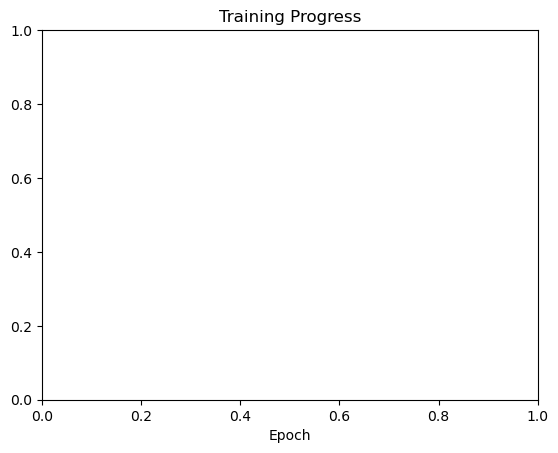

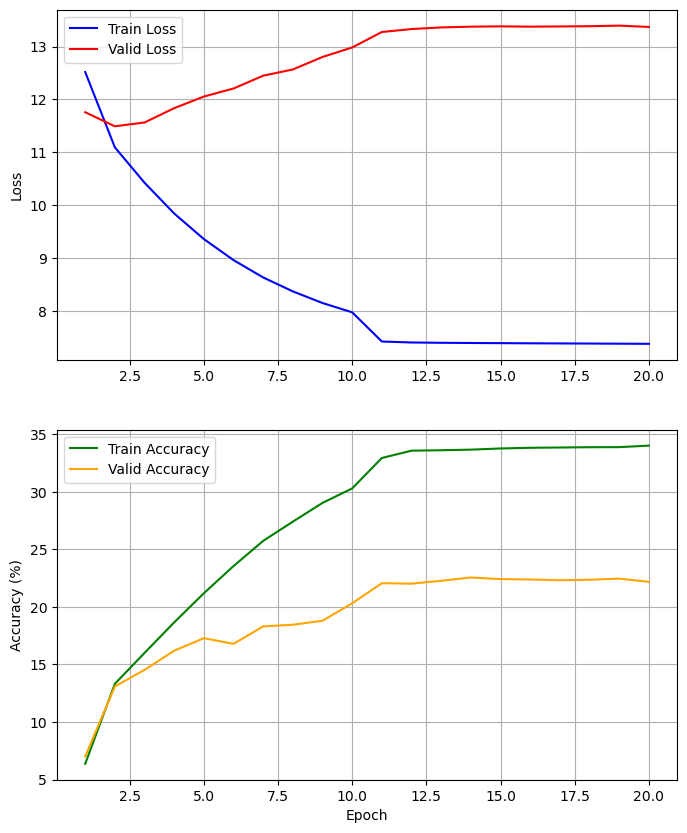

Epoch [20/20], Train Loss: 7.3825, Train Accuracy: 34.02%, Validation Loss: 13.3707, Validation Accuracy: 22.18%


/tmp/ipykernel_3380/1143003353.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model2.pth'))


In [174]:
model, history = train(model, train_loader, test_loader, optimizer, scheduler, num_epochs=20, device=device)

In [209]:
model.load_state_dict(torch.load('best_valid_model.pth'))

/tmp/ipykernel_3380/1044563062.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_valid_model.pth'))


<All keys matched successfully>

In [210]:
evaluate(model, test_loader, device=device)

Test Loss: 12.9955, Test Accuracy: 30.37%


(12.995480806236491, 30.367360397230247)

In [211]:
def recommend_books(model, user_id, n_recommendations=5, device="cpu"):
    model.eval()

    user_tensor = torch.tensor([user_id], dtype=torch.long).to(device)
    
    with torch.no_grad():
        book_ids = torch.arange(0, n_books, dtype=torch.int64).to(device)
        ratings_pred = model(user_tensor.repeat(n_books), book_ids)

    ratings_pred = ratings_pred.squeeze().cpu().numpy()

    top_indices = ratings_pred.argsort()[-n_recommendations:][::-1] 

    top_ratings = ratings_pred[top_indices]

    return top_indices.tolist(), top_ratings.tolist()


In [250]:
sample = books_with_rating_df.sample(1)
user_id = sample['User-ID_code'].values[0]

recommend_books_ids, book_ratings = recommend_books(model, user_id, n_recommendations=5, device=device)

recommendations = []
for rec_id in recommend_books_ids:
    book_isbn = books_with_rating_df.loc[books_with_rating_df['ISBN_code'] == rec_id]['ISBN'].values[0]
    book = books_df.loc[books_df['ISBN'] == book_isbn]
    title = book['Book-Title'].values[0]
    author = book['Book-Author'].values[0]
    year_published = book['Year-Of-Publication'].values[0]

    recommendations.append({
        'title': title,
        'author': author,
        'year-Published': year_published
    })

print('-'*30)
print(f"Recommended books for user {user_id}:")
for idx, rec in enumerate(recommendations):
    print(f"Rank {idx + 1} with rating {book_ratings[idx]}: Title {rec['title']}, Author {rec['author']}, Year Published {rec['year-Published']}")
print('-'*30)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
